In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import joblib
import seaborn as sns
import matplotlib.pyplot as plt

# Load sample dataset
file_path = 'indiancrop_dataset.csv'
data = pd.read_csv(file_path)

In [2]:
# Split dataset into features and target
X = data.drop(columns=["CROP"])
y = data["CROP"]

# One-hot encode categorical features
X = pd.get_dummies(X, columns=["STATE"], drop_first=True)

# Scale numerical features
scaler = StandardScaler()
numerical_features = ["N_SOIL", "P_SOIL", "K_SOIL", "TEMPERATURE", "HUMIDITY", "ph", "RAINFALL"]
X[numerical_features] = scaler.fit_transform(X[numerical_features])

# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Save the scaler and label encoder
joblib.dump(scaler, "scaler.pkl")
joblib.dump(label_encoder, "label_encoder.pkl")

['label_encoder.pkl']

In [3]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Initialize the model
gb_model = GradientBoostingClassifier(random_state=42)

# Perform stratified k-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(gb_model, X_train, y_train, cv=cv, scoring="accuracy")
print(f"Cross-Validation Accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

# Fit the model
gb_model.fit(X_train, y_train)

# Save the model
joblib.dump(gb_model, "gradient_boosting_crop_model.pkl")
print("Model saved to gradient_boosting_crop_model.pkl")

Cross-Validation Accuracy: 0.9955 ± 0.0064
Model saved to gradient_boosting_crop_model.pkl


In [4]:
# Predictions and evaluation
y_pred = gb_model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_test, y_pred, average='weighted'):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred, average='weighted'):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


Accuracy: 0.9977
Precision: 0.9978
Recall: 0.9977
F1 Score: 0.9977

Classification Report:
              precision    recall  f1-score   support

       Apple       1.00      1.00      1.00        20
      Banana       1.00      1.00      1.00        20
   Blackgram       1.00      1.00      1.00        20
    ChickPea       1.00      1.00      1.00        20
     Coconut       1.00      0.95      0.97        20
      Coffee       1.00      1.00      1.00        20
      Cotton       1.00      1.00      1.00        20
      Grapes       1.00      1.00      1.00        20
        Jute       0.95      1.00      0.98        20
 KidneyBeans       1.00      1.00      1.00        20
      Lentil       1.00      1.00      1.00        20
       Maize       1.00      1.00      1.00        20
       Mango       1.00      1.00      1.00        20
   MothBeans       1.00      1.00      1.00        20
    MungBean       1.00      1.00      1.00        20
   Muskmelon       1.00      1.00      1.00 

In [5]:
# Hyperparameter tuning using GridSearchCV
param_grid = {
    "n_estimators": [100, 200],
    "learning_rate": [0.01, 0.1],
    "max_depth": [3, 5],
}
grid_search = GridSearchCV(gb_model, param_grid, cv=cv, scoring="accuracy", n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Accuracy: {grid_search.best_score_:.4f}")

# Update model with best parameters
best_model = grid_search.best_estimator_

Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Best Cross-Validation Accuracy: 0.9955


<Figure size 1000x600 with 0 Axes>

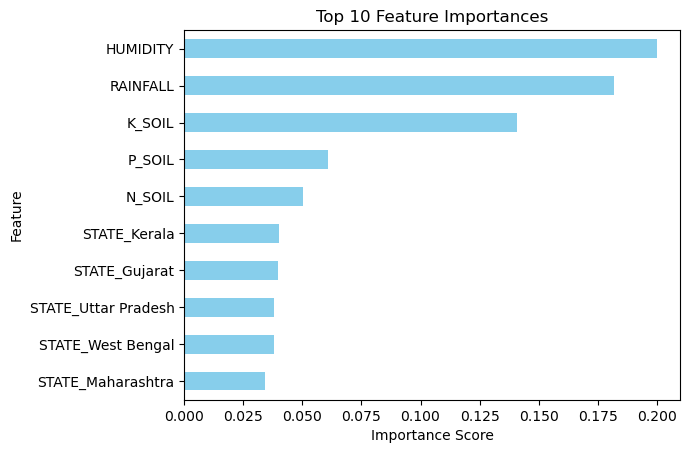

In [6]:
# Feature importance visualization
importances = gb_model.feature_importances_
feature_importances = pd.DataFrame({
    "Feature": X.columns,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 6))
feature_importances.head(10).plot(kind="barh", x="Feature", y="Importance", legend=False, color="skyblue")
plt.title("Top 10 Feature Importances")
plt.xlabel("Importance Score")
plt.gca().invert_yaxis()
plt.show()
